### **Create figures for paper**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from matplotlib.patches import Ellipse
from lime import lime_image
from skimage.segmentation import mark_boundaries
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from skimage.segmentation import slic
import time

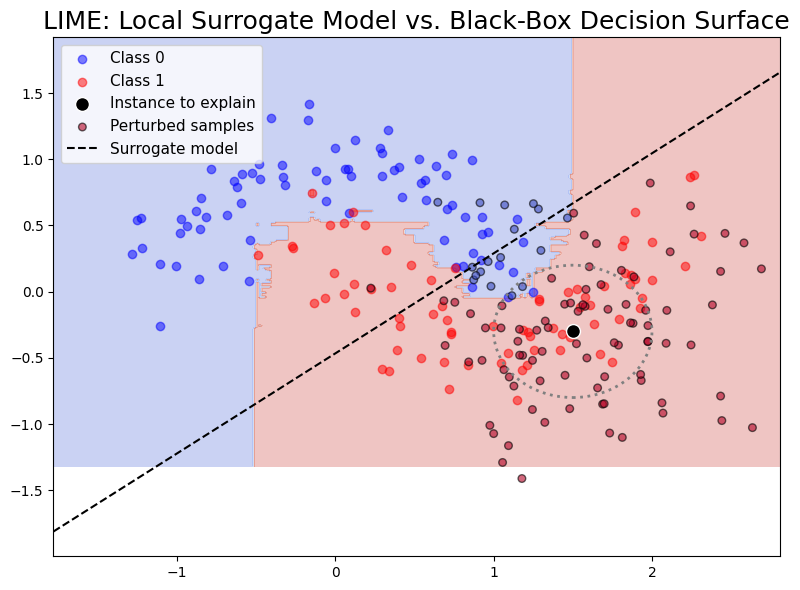

In [38]:
X, y = make_moons(n_samples=150, noise=0.2, random_state=42)

black_box_model = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42))
black_box_model.fit(X, y)

instance = np.array([[1.5, -0.3]])

np.random.seed(0)
perturbation_radius = 0.5
perturbed_samples = instance + np.random.normal(0, perturbation_radius, size=(100, 2))
perturbed_preds = black_box_model.predict(perturbed_samples)

surrogate = LogisticRegression()
surrogate.fit(perturbed_samples, perturbed_preds)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
Z = black_box_model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='blue', label='Class 0', alpha=0.5)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='red', label='Class 1', alpha=0.5)
plt.scatter(instance[:, 0], instance[:, 1], c='black', s=100, edgecolor='white', label='Instance to explain')
plt.scatter(perturbed_samples[:, 0], perturbed_samples[:, 1], c=perturbed_preds, cmap='coolwarm', edgecolor='k', alpha=0.6, s=30, label='Perturbed samples')

coef = surrogate.coef_[0]
intercept = surrogate.intercept_[0]
x_vals = np.array([x_min, x_max])
y_vals = -(coef[0] * x_vals + intercept) / coef[1]
plt.plot(x_vals, y_vals, '--', color='black', label='Surrogate model')

ellipse = Ellipse(xy=instance[0], width=1.0, height=1.0, edgecolor='gray', fc='None', lw=2, ls=':')
plt.gca().add_patch(ellipse)

plt.title("LIME: Local Surrogate Model vs. Black-Box Decision Surface", fontsize = 18)
plt.legend(fontsize = 11)
plt.tight_layout()
plt.savefig("../outputs/lime_surrogate.pdf")
plt.show()

### **Showing LIME outputs**

In [ ]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.eval()

In [40]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

img_path = "../data/figure_data/dog_and_cat.jpg"
img = Image.open(img_path).convert('RGB')
input_tensor = preprocess(img).unsqueeze(0)

In [41]:
def custom_segmentation(image):
    return slic(image, n_segments=50, compactness=10, sigma=1)

In [ ]:
def batch_predict(images):
    model.eval()
    batch = torch.stack([preprocess(Image.fromarray(img)) for img in images], dim=0)
    with torch.no_grad():
        outputs = model(batch)
        return outputs.softmax(1).numpy()
    
input_tensor = preprocess(img).unsqueeze(0)
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = output.argmax(dim=1).item()

100%|██████████| 1000/1000 [00:59<00:00, 16.77it/s]


In [ ]:
start = time.time()
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    np.array(img),
    batch_predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000,
    segmentation_fn=custom_segmentation
)
end = time.time()
duration = end - start
print(duration)

In [81]:
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=3,
    hide_rest=True
)

In [82]:
from torchvision.models import ResNet50_Weights
class_names = ResNet50_Weights.DEFAULT.meta["categories"]
print(f"Predicted class: {predicted_class} = {class_names[predicted_class]}")

Predicted class: 213 = Irish setter


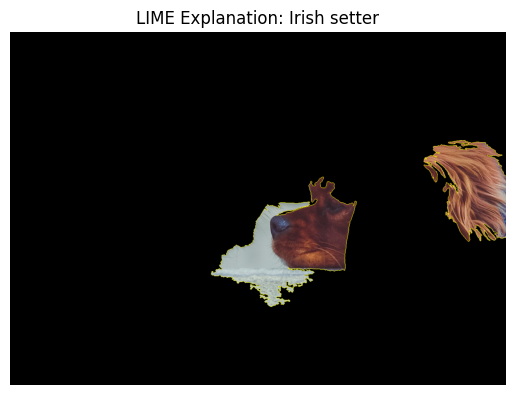

In [83]:
plt.imshow(mark_boundaries(temp / 255.0, mask, color=(1, 1, 0)))
plt.title(f"LIME Explanation: {class_names[predicted_class]}")
plt.axis('off')
plt.savefig("../outputs/lime_hide_rest.pdf")
plt.show()

### **Side by Side**

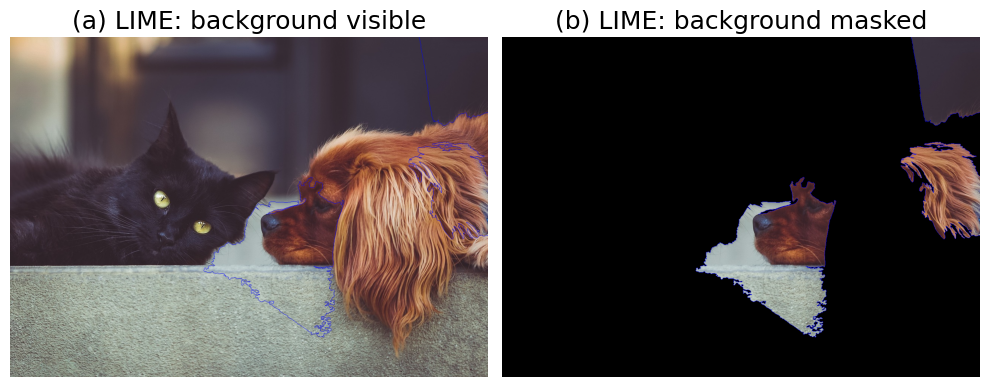

In [ ]:
temp1, mask1 = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

temp2, mask2 = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=True
)

img1 = mark_boundaries(temp1 / 255.0, mask1, color=(0, 0, 1))  # blue
img2 = mark_boundaries(temp2 / 255.0, mask2, color=(0, 0, 1))  # blue

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].imshow(img1)
axs[0].set_title("(a) LIME: background visible", fontsize = 18)
axs[0].axis('off')

axs[1].imshow(img2)
axs[1].set_title("(b) LIME: background masked", fontsize = 18)
axs[1].axis('off')

plt.tight_layout()
plt.savefig("../outputs/lime_side_by_side.pdf", format='pdf', bbox_inches='tight')
plt.show()

**Notes on performance, ease of use**

* harder to use, more parameters, custom segmentation to get results that are shown online
* slow (1000 perturbations)